In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


In [2]:

# Generate synthetic data for binary classification
X, y = make_classification(
    n_samples=1000, n_features=10, n_informative=8, n_redundant=2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [3]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)  # Input layer to hidden layer
        self.fc2 = nn.Linear(16, 1)          # Hidden layer to output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x



In [4]:
# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = SimpleNN(input_size)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.RMSprop(model.parameters(), lr=0.01)
# optimizer = optim.Adagrad(model.parameters(), lr=0.01)

# Training the model
epochs = 500
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/500], Loss: 0.7143
Epoch [20/500], Loss: 0.6999
Epoch [30/500], Loss: 0.6857
Epoch [40/500], Loss: 0.6714
Epoch [50/500], Loss: 0.6569
Epoch [60/500], Loss: 0.6420
Epoch [70/500], Loss: 0.6269
Epoch [80/500], Loss: 0.6120
Epoch [90/500], Loss: 0.5972
Epoch [100/500], Loss: 0.5829
Epoch [110/500], Loss: 0.5690
Epoch [120/500], Loss: 0.5556
Epoch [130/500], Loss: 0.5427
Epoch [140/500], Loss: 0.5305
Epoch [150/500], Loss: 0.5189
Epoch [160/500], Loss: 0.5079
Epoch [170/500], Loss: 0.4974
Epoch [180/500], Loss: 0.4875
Epoch [190/500], Loss: 0.4782
Epoch [200/500], Loss: 0.4694
Epoch [210/500], Loss: 0.4608
Epoch [220/500], Loss: 0.4527
Epoch [230/500], Loss: 0.4449
Epoch [240/500], Loss: 0.4373
Epoch [250/500], Loss: 0.4299
Epoch [260/500], Loss: 0.4227
Epoch [270/500], Loss: 0.4155
Epoch [280/500], Loss: 0.4085
Epoch [290/500], Loss: 0.4017
Epoch [300/500], Loss: 0.3951
Epoch [310/500], Loss: 0.3887
Epoch [320/500], Loss: 0.3826
Epoch [330/500], Loss: 0.3766
Epoch [340/500], Lo

In [5]:

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred >= 0.5).float()
    accuracy = accuracy_score(y_test, y_pred_class.numpy())
    print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8750


In [6]:
import optuna
import numpy as np


# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)



# Define the dynamic model
class DynamicNN(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size):
        super(DynamicNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))  # Output layer
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter search space
    num_layers = trial.suggest_int("num_layers", 1, 5)  # Number of hidden layers
    hidden_size = trial.suggest_int("hidden_size", 16, 128)  # Neurons per layer
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    num_epochs = trial.suggest_int("epochs", 10, 50)  # Number of epochs

    # Cross-validation
    k_folds = 15
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_losses = []

    for train_idx, val_idx in kf.split(X_tensor):
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        # Initialize model and optimizer
        model = DynamicNN(input_size=X_tensor.shape[1], num_layers=num_layers, hidden_size=hidden_size)
        criterion = nn.BCELoss()
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
        

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
#        with torch.no_grad():
#            val_outputs = model(X_val)
#            val_loss = criterion(val_outputs, y_val)
#            fold_losses.append(val_loss.item())
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        trial.report(val_loss.item(), epoch)

        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Append final loss if not pruned
        fold_losses.append(val_loss.item())
    # Return average validation loss across folds
    return np.mean(fold_losses)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2024-11-29 13:31:51,917] A new study created in memory with name: no-name-c10d6388-0ab4-427d-9d62-f8c9d6e0ef11
C:\Users\cevatenesk\AppData\Local\Temp\ipykernel_6496\4206257904.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
c:\Users\cevatenesk\AppData\Local\anaconda3\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
[I 2024-11-29 13:31:52,897] Trial 0 finished with value: 0.24906530479590097 and parameters: {'num_layers': 5, 'hidden_size': 62, 'lr': 0.0006661934073876113, 'optimizer': 'RMSprop', 'epochs': 31}. Best is trial 0 with value: 0.24906530479590097.
c:\Users\cevatenesk\AppData\Local\anaconda3\Lib\site-packages\optuna\trial\_trial.py:497: 

Best hyperparameters: {'num_layers': 2, 'hidden_size': 102, 'lr': 0.006409536211380866, 'optimizer': 'Adam', 'epochs': 49}


In [7]:
# Retrieve the best hyperparameters
best_params = study.best_params
# Train and evaluate using the best parameters
best_model = DynamicNN(
    input_size=X_train_tensor.shape[1],
    num_layers=best_params["num_layers"],
    hidden_size=best_params["hidden_size"]
)
criterion = nn.BCELoss()
optimizer = getattr(optim, best_params["optimizer"])(best_model.parameters(), lr=best_params["lr"])

# Train the model on the entire training set
num_epochs = best_params["epochs"]
train_losses = []  
for epoch in range(num_epochs):
    best_model.train()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on the test set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    test_predictions = (test_outputs >= 0.5).float()  # Convert probabilities to binary predictions
    test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9200


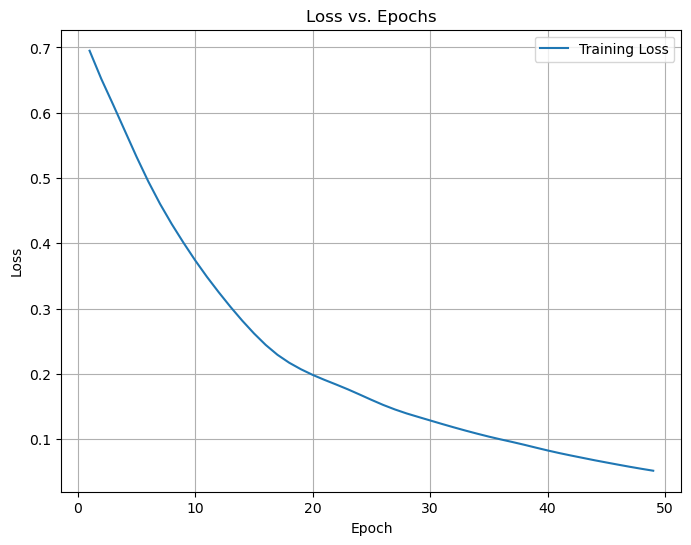

In [9]:
import matplotlib.pyplot as plt


# Visualization
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()